In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Domanda 1

Si scriva una funzione che simuli il cammino degli abitanti del villaggio dopo aver bevuto la grappa,
assumendo che si spostino in piano, che ogni passo abbia direzione casuale uniforme angolarmente
ed una lunghezza distribuita secondo una distribuzione Gaussiana con media 1 e larghezza 0.2,
troncata a valori positivi.

In [2]:
from myrand import generate_range, rand_TCL_ms

In [3]:
def cammino(N):
            
    #tronco la gaussiana ai valori positivi
    steps = []
    for i in range(N):
        step = rand_TCL_ms(1, 0.2) 
        if step <= 0: steps.append(0)
        if step > 0: steps.append(step)
   
    axis = generate_range(0, 2*np.pi, N)       #assi del piano 
    dx = steps*np.cos(axis)                    #spostamento sulle x
    dy = steps*np.sin(axis)                    #spostamento sulle y
    x = np.cumsum(dx)                          #posizione sulle x
    y = np.cumsum(dy)                          #posizione sulle y
    dist = ((x[N-1])**2 + (y[N-1])**2)** 0.5   #posizione finale
    return x, y, dist

# Domanda 2

Immaginando che il calderone si trovi alle coordinate (0, 0) sul piano, si scriva una funzione che
calcoli la posizione (x, y) raggiunta da Asterix dopo N = 10 passi e si disegni il suo percorso.

La posizione di Asterix è: (-1.64, 2.40)


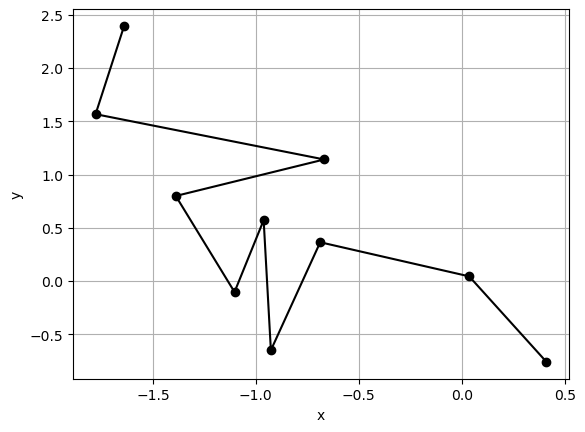

In [9]:
N = 10
x, y, dist = cammino(N)
maxx = x[N-1]
maxy = y[N-1]
print(f'La posizione di Asterix è: ({maxx:.2f}, {maxy:.2f})')

fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.plot(x, y, marker = 'o', color = 'black');
ax.set_ylabel('y');
ax.set_xlabel('x');
plt.grid()

# Domanda 3

Si consideri ora l’intera popolazione: si determini la posizione (x, y) di ogni abitante dopo N =
10 passi a partire dal calderone e si disegni le distribuzione della distanza raggiunta dal punto di
partenza, assumendo la popolazione totale composta da 10000 persone.

In [10]:
from mix import sturges

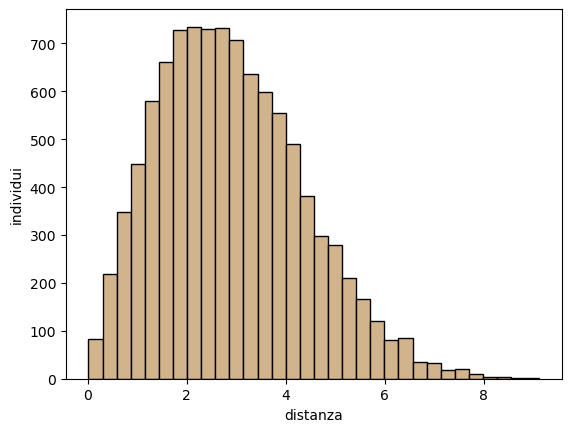

In [11]:
N_toy = 10000

distanza = []

# tramite un toy experiment simulo 10000 volte 10 passi di un abitante

for i in range(N_toy):
  N = 10
  x, y, dista = cammino(N)
  distanza.append(dista)

# effettuo l'operazione di binning

bin = sturges(N_toy)
bin_content, bin_edges = np.histogram(distanza, bin)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.hist(distanza, bin_edges, edgecolor = 'black', color = 'tan');
ax.set_xlabel('distanza');
ax.set_ylabel('individui');

# Domanda 4

Si determinino media, varianza, asimmetria e curtosi della distribuzione ottenuta.

In [12]:
from stats import stats

In [13]:
#applico ai dati una classe che calcoli automaticamente i valori

stat = stats(distanza)
mean = stat.mean()
var = stat.variance()
asi = stat.skewness()
kurt = stat.kurtosis()

print(f'Media: {mean:.3f}\n')
print(f'Varianza: {var:.3f}\n')
print(f'Asimmetria: {asi:.3f}\n')
print(f'Curtosi: {kurt:.3f}\n')

Media: 2.902

Varianza: 2.159

Asimmetria: 0.520

Curtosi: -0.040



# Domanda 5

Se la lunghezza dei passi è costante uguale ad 1, la distribuzione delle distanze r dopo N passi segue
una distribuzione di Rayleigh.
Si utilizzi un fit per determinare, a partire dalla distribuzione di distanze costruita in queste ipotesi,
il numero di passi effettuati, sapendo che la distribuzione di Rayleigh è presente in scipy come
scipy.stats.rayleigh e che per ottenere la forma funzionale di interesse per il problema questa
distribuzione ha come parametri loc = 0 e scale = √N/2 (dove N è il numero di passi).

In [27]:
def cammino_1(N):
    step = np.full(N, 1)                       #lunghezza dei passi costante
    axis = generate_range(0, 2*np.pi, N)       #assi del piano          
    dx = step*np.cos(axis)                     #spostamento su x
    dy = step*np.sin(axis)                     #spostamento su y
    x = np.cumsum(dx)                          #posizione x
    y = np.cumsum(dy)                          #posizione y
    dist = ((x[N-1])**2 + (y[N-1])**2)** 0.5
    return dist

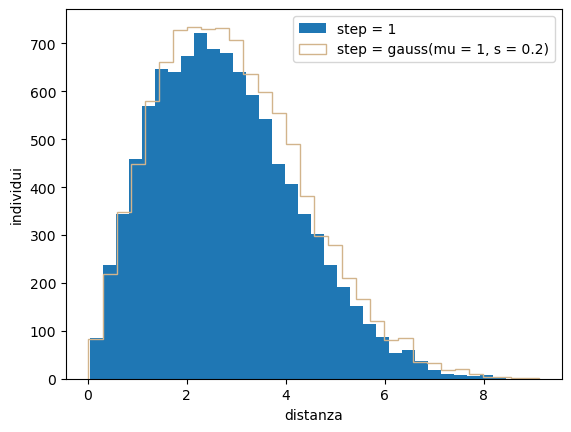

In [78]:
#ripeto il toy

distanz = []

for i in range(N_toy):
  dist = cammino_1(N)
  distanz.append(dist)

bin_content2, bin_edges2 = np.histogram(distanz, bin)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.hist(distanz, bin_edges2, label = 'step = 1');
ax.hist(distanza, bin_edges, histtype = 'step', color = 'tan', label = 'step = gauss(mu = 1, s = 0.2)');
ax.set_xlabel('distanza');
ax.set_ylabel('individui');
ax.legend();

In [79]:
from scipy.stats import rayleigh
from iminuit import Minuit
from iminuit.cost import ExtendedBinnedNLL

In [80]:
def mod_total(bin_edges, N_signal, n):
    return N_signal * rayleigh.cdf(bin_edges, 0, np.sqrt(n/2))

my_cost_func = ExtendedBinnedNLL(bin_content2, bin_edges2, mod_total)

fit = Minuit(my_cost_func, N_signal = N_toy, n = 10)

fit.migrad()
fit.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 26.54 (χ²/ndof = 0.9)      │              Nfcn = 39               │
│ EDM = 7.74e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal │  10.01e3  │  0.10e3   │            │            │         │         │       │
│ 1 │ n        │   9.92    │   0.10    │            │            │         │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────┐
│          │ N_signal        n │
├──────────┼───────────────────┤
│ N_signal │    1e+04    0.053 │
│        n │    0.053   0.0102 │
└──────────┴───────────────────┘

In [31]:
numero = fit.values['n']
print(f'Numero di passi stimato a partire dai dati: {numero:.2f}')

Numero di passi stimato a partire dai dati: 9.99
